${\Huge \text{Cluster job tutorial}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** Example of how to use the `Selene_Job` class to send a job to the cluster directly from your local notebook.

This notebook is divided in 3 parts:
* **1. A classic machine learning task example (Gaussian Naive Bayes)**
* **2. How to run the same example on the cluster**
* **3. A more computationally expensive example (grid search on Random Forest)**

***

In [1]:
# load python custom functions
%run ../../utils/Python/setup_environment.ipy

Setup environment... done!


<span style="color:green">✅ Working on **imp-ann_env** conda environment.</span>

# A classic machine learning task example (Gaussian Naive Bayes)

In [2]:
data = Impact_Wrapper('../../data/processed/annotated_final_IMPACT_mutations_20181105.txt', 'is_artefact')

features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
            'gene_type']

X, y = data.process(features).get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (225022, 45) | y: (225022,)


,count_,freq_
False,218173,96.96%
True,6849,3.04%


The code below is at the heart of the computation, it runs the chosen model on the data. This is the code that we want to run on the cluster.

In [3]:
# choose cross-validation strategy
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)

# choose a model
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      GaussianNB())

# run the model
metrics = Metrics(model, X, y, cv_strategy)

Run model... done! (20.14s)


When we have the metrics we can print/plot any relevant information we want:

In [4]:
metrics.print_mean()

▴ Mean average_precision: 0.237 ± 0.012
▴ Mean roc_auc          : 0.811 ± 0.009
▴ Mean precision        : 0.373 ± 0.019
▴ Mean recall           : 0.363 ± 0.012
▴ Mean f1               : 0.368 ± 0.013
▴ Mean accuracy         : 0.962 ± 0.001


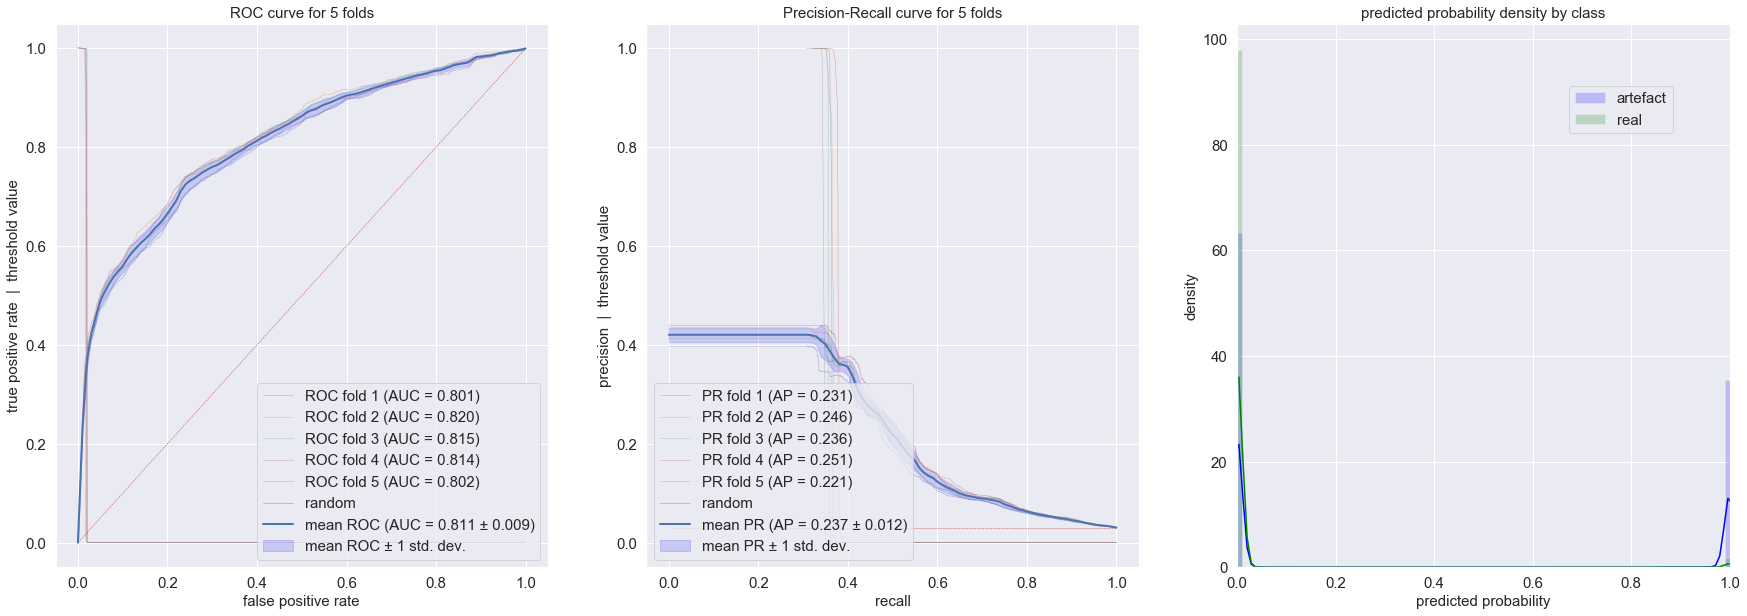

In [5]:
metrics.plot_threshold_decision_curves()

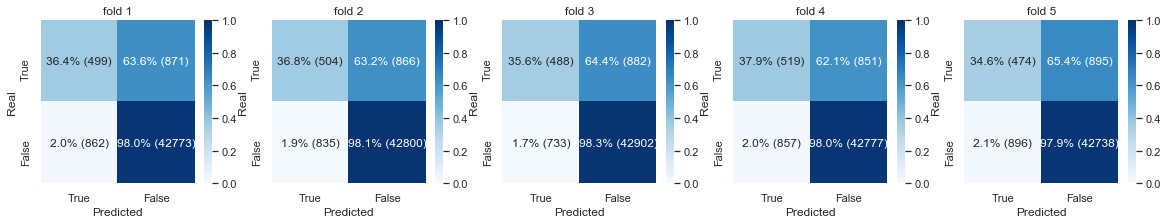

In [6]:
metrics.plot_confusion_matrix()

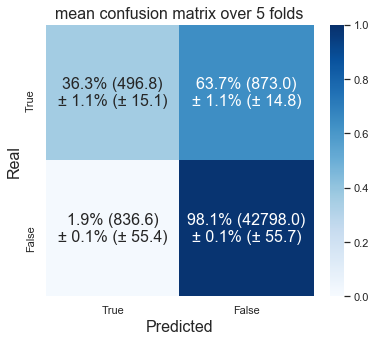

In [7]:
metrics.plot_mean_confusion_matrix()

# How to run the same example on the cluster

## Setup the `Selene_Job` class

In [8]:
# load the Selene_Job class
%run ../../utils/Python/selene_job.ipy

A job is:
* identified by its job id (`cluster_tutorial_Gaussian_NB`)
* referring to a cluster user (`guilminp`)
* refering to an impact-annotator_v2 ssh_remote_jobs path on the cluster (`/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs`)
* referring to a local path to ssh_remote_jobs (`artefact_classification/ssh_remote_jobs`)

This three last parameters can be specified for every default created job by specifying them after loading the `Selene_Job` class:

In [9]:
# setup the cluster username, and paths to necessary cluster directories
Selene_Job.cluster_username             = 'guilminp'
Selene_Job.ssh_remote_jobs_cluster_path = '/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs'
Selene_Job.ssh_remote_jobs_local_path   = 'artefact_classification/ssh_remote_jobs'

## Create a job

Because we specified the basic default parameters to create a job, we just need to give its id ( = name):

In [10]:
job = Selene_Job('cluster_tutorial_Gaussian_NB')

➞ mkdir on local computer artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ created

You can also decide to load a previously created job, for example if we want to find back the previous job after logging out:

In [11]:
same_job = Selene_Job('cluster_tutorial_Gaussian_NB', load_from_id=True)

<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ job found and reloaded

Creating an already existing job won't work: 

In [12]:
job = Selene_Job('cluster_tutorial_Gaussian_NB')

<span style="color:red">Job < cluster_tutorial_Gaussian_NB >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

## Load the data used by the job

The following saves `X` and `y` objects as pickle objects in the job directory (`artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB`). This allows to separate the creation of the dataset (feature selection, formating, etc...) from the run of the machine learning model.

In [13]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ data loaded

## Write the job python script

Here we write the ipython script that will be run in the cluster, it is stored in the `script.ipy` file in the local `artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB` folder. Notice that we litteraly copy-paste what we would have written to run the job on a local notebook (ie what we wrote in part 1).

In [14]:
job.script_path

'artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB/script.ipy'

In [15]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')


###############################################
## EXACT SAME CODE AS IN PART ONE (until ## END)

# choose cross-validation strategy
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)

# choose a model
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      GaussianNB())

# run the model
metrics = Metrics(model, X, y, cv_strategy)

## END
###############################################


# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB/script.ipy


## Run the job in the cluster

The following command copy the job directory on the cluster, setup the cluster environment and then bsub the job. You can specify the number of jobs, wether it is a short job or not, and the amount of memory in GB per CPU (`memory=None` will assign the default cluster memory value to each CPU):

In [16]:
job.run(n_jobs=1, short_job=True, memory=None) # by default n_jobs=1, short_job=True, memory=None

➞ scp artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB
script.ipy                                    100%  968   118.2KB/s   00:00    
X.pkl                                         100%   50MB  13.9MB/s   00:03    
y.pkl                                         100% 3736KB  14.1MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB
Job <31381779> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J cluster_tutorial_Gaussian_NB -We 59 "ipython script.ipy"


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ submitted<br>

⚠️ IMPORTANT NOTE: one of the reason your job always fails to launch could be that your local computer doesn't automatically allow the ssh-connection to the cluster, make sure that you followed this tutorial (http://mskcchpc.org/display/CLUS/Secure+Shell+SSH) closely including running:
```bash
$ ssh-add my_passphrase
```
You should be able to connect to the cluster from a terminal without having to enter any password.

## Get the results of the job

If the job is not done yet we get this result:

In [17]:
job.get_results()

<span style="color:red">Job < cluster_tutorial_Gaussian_NB >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

If it's done, we get this result:

In [18]:
job.get_results()

<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB to artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB
metrics.pkl                                   100% 7537KB   8.9MB/s   00:00    
job_output.txt                                100% 1286   307.7KB/s   00:00    
➞ load metrics.pkl in object self.metrics


Once the job results have been downloaded on your local computer you can also get the results from the local job directory:

In [19]:
job.get_local_results()

<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ local results found<br>

➞ load metrics.pkl in object self.metrics


⚠️ This means there are two copies of the job results, one on the cluster and one on your local computer, one may be different from the other so be sure to always use `job.get_results()` to get the most recent results (the ones on the cluster).

In [20]:
job.metrics.print_mean()

▴ Mean average_precision: 0.237 ± 0.012
▴ Mean roc_auc          : 0.811 ± 0.009
▴ Mean precision        : 0.373 ± 0.019
▴ Mean recall           : 0.363 ± 0.012
▴ Mean f1               : 0.368 ± 0.013
▴ Mean accuracy         : 0.962 ± 0.001


In [21]:
job.metrics.print_fold_details()

Fold #: [fit_time | score_time]
  → score_name_1: [test_score_1 | train_score_1]
  → score_name_2: [test_score_2 | train_score_2]
  → ...

Fold 1: [4.71s | 0.55s]
  → average_precision: [0.231 | 0.238]
  → roc_auc          : [0.801 | 0.813]
  → precision        : [0.367 | 0.366]
  → recall           : [0.364 | 0.368]
  → f1               : [0.365 | 0.367]
  → accuracy         : [0.961 | 0.961]
Fold 2: [0.85s | 0.41s]
  → average_precision: [0.246 | 0.234]
  → roc_auc          : [0.820 | 0.808]
  → precision        : [0.376 | 0.366]
  → recall           : [0.368 | 0.367]
  → f1               : [0.372 | 0.366]
  → accuracy         : [0.962 | 0.961]
Fold 3: [0.90s | 0.43s]
  → average_precision: [0.236 | 0.231]
  → roc_auc          : [0.815 | 0.805]
  → precision        : [0.400 | 0.403]
  → recall           : [0.356 | 0.350]
  → f1               : [0.377 | 0.375]
  → accuracy         : [0.964 | 0.964]
Fold 4: [0.87s | 0.43s]
  → average_precision: [0.251 | 0.237]
  → roc_auc          : [

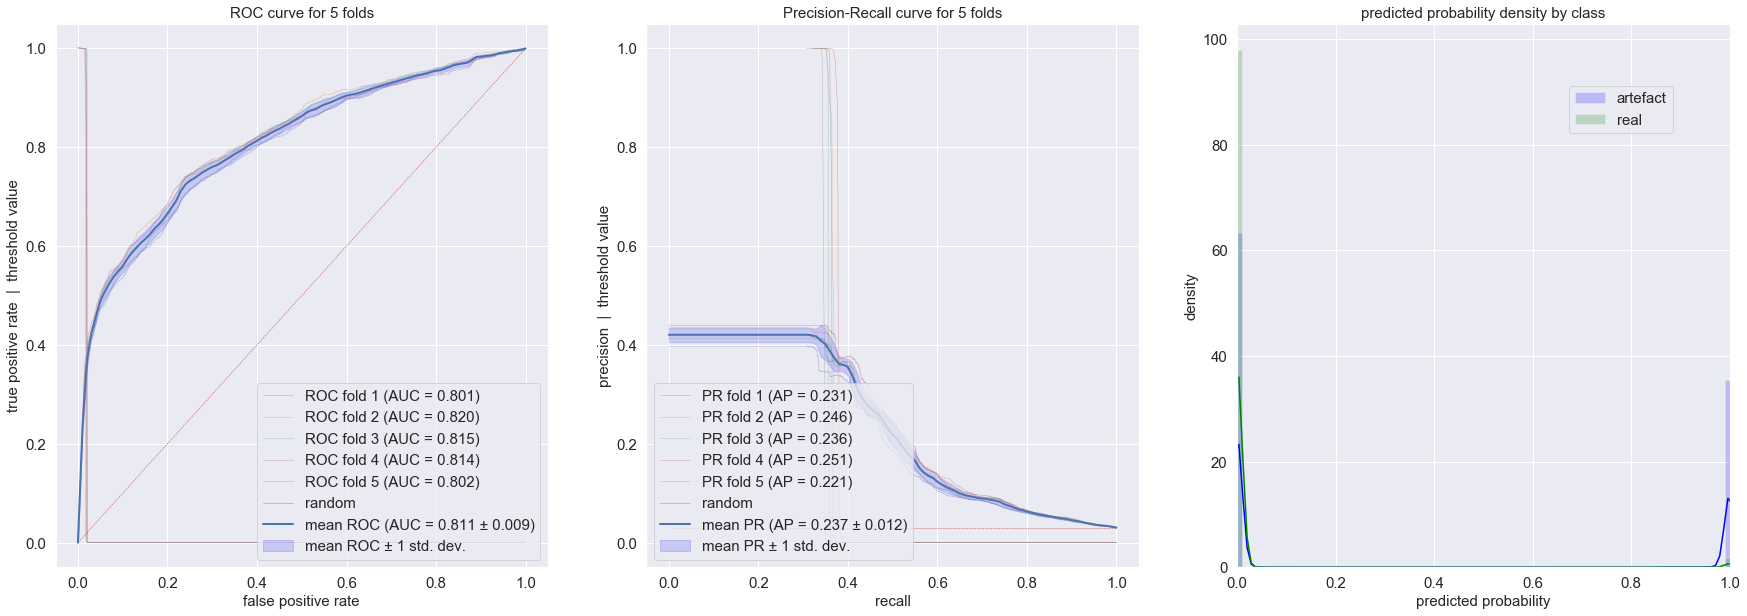

In [22]:
job.metrics.plot_threshold_decision_curves()

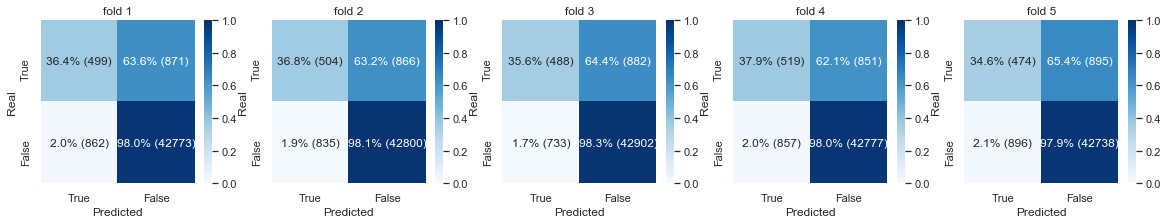

In [23]:
job.metrics.plot_confusion_matrix()

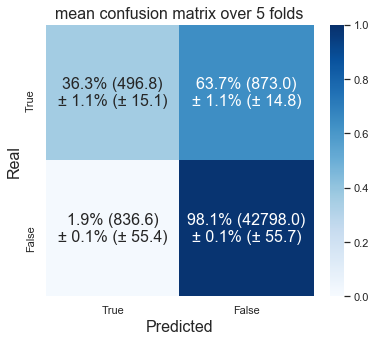

In [24]:
job.metrics.plot_mean_confusion_matrix()

We can remove the job with the following command (it will delete the job directory in the cluster and on the local computer):

In [25]:
job.remove()

➞ rm on local computer artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB
➞ rm on cluster /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ removed from local computer and cluster<br>

## Run the job elsewhere

You can also manually specify the cluster username, the ssh_remote jobs cluster path and the ssh_remote_jobs local path if you want to ignore the default parameters you defined:

In [26]:
# create a job with different local and cluster ssh_remote_jobs path, we could also have change the cluster username
job_elsewhere = Selene_Job('cluster_tutorial_Gaussian_NB', 'guilminp', '/home/guilminp', '.')

➞ mkdir on local computer ./job_cluster_tutorial_Gaussian_NB


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ created

In [27]:
job_elsewhere.remove()

➞ rm on local computer ./job_cluster_tutorial_Gaussian_NB
➞ rm on cluster /home/guilminp/job_cluster_tutorial_Gaussian_NB


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ removed from local computer and cluster<br>

# A more computationally expensive example (grid search on Random Forest)

In [28]:
job = Selene_Job('cluster_tutorial_GS_Random_Forest')
job.load_data(X, y)

➞ mkdir on local computer artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest


<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ created

➞ save X.pkl & y.pkl in artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest


<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ data loaded

In [29]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

###############################################
## RELEVANT CODE (until ## END)

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
parameters_grid = [
                    {'randomforestclassifier__n_estimators': [10, 20, 30],
                     'randomforestclassifier__criterion': ['gini', 'entropy'],
                     'randomforestclassifier__max_depth': [5, 10]}
                  ]

pipe = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                     RandomForestClassifier(random_state=42))
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=20)

## END
###############################################

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest/script.ipy


In [30]:
job.run(n_jobs=20, short_job=True, memory=8) # 20 jobs each having 8GB memory

➞ scp artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
script.ipy                                    100% 1391   148.8KB/s   00:00    
X.pkl                                         100%   50MB  16.6MB/s   00:03    
y.pkl                                         100% 3736KB   4.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
Job <31381782> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J cluster_tutorial_GS_Random_Forest -We 59 -n 20 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ submitted<br>

In [31]:
job.get_results()

<span style="color:red">Job < cluster_tutorial_GS_Random_Forest >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [32]:
job.get_results()

<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest to artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
metrics.pkl                                   100% 5892KB   8.6MB/s   00:00    
job_output.txt                                100% 1465   191.6KB/s   00:00    
➞ load metrics.pkl in object self.metrics


In [33]:
job.metrics.print_mean()

▴ Mean average_precision: 0.472 ± 0.018
▴ Mean roc_auc          : 0.873 ± 0.010
▴ Mean precision        : 0.167 ± 0.010
▴ Mean recall           : 0.699 ± 0.013
▴ Mean f1               : 0.269 ± 0.014
▴ Mean accuracy         : 0.884 ± 0.007


In [34]:
job.metrics.print_fold_details()

Fold #: [fit_time | score_time]
  → score_name_1: [test_score_1 | train_score_1]
  → score_name_2: [test_score_2 | train_score_2]
  → ...
  → best hyperparameters: {'hyperparameter_name_1': best_value, ...}

Fold 1: [39.49s | 0.94s]
  → average_precision: [0.460 | 0.515]
  → roc_auc          : [0.864 | 0.889]
  → precision        : [0.158 | 0.167]
  → recall           : [0.687 | 0.735]
  → f1               : [0.257 | 0.272]
  → accuracy         : [0.879 | 0.880]
  → best hyperparameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 30}
Fold 2: [39.84s | 0.97s]
  → average_precision: [0.458 | 0.506]
  → roc_auc          : [0.875 | 0.887]
  → precision        : [0.170 | 0.174]
  → recall           : [0.701 | 0.719]
  → f1               : [0.274 | 0.281]
  → accuracy         : [0.887 | 0.888]
  → best hyperparameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'ran

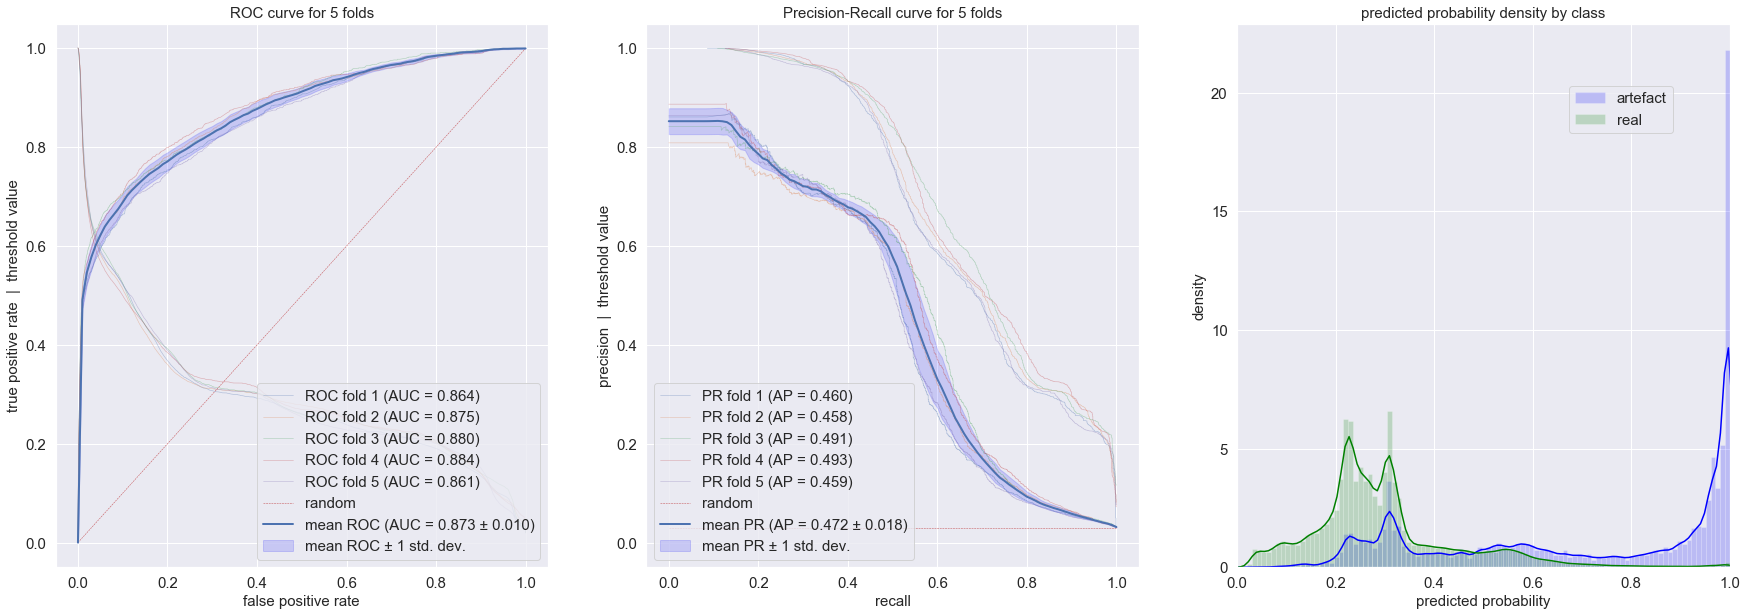

In [35]:
job.metrics.plot_threshold_decision_curves()

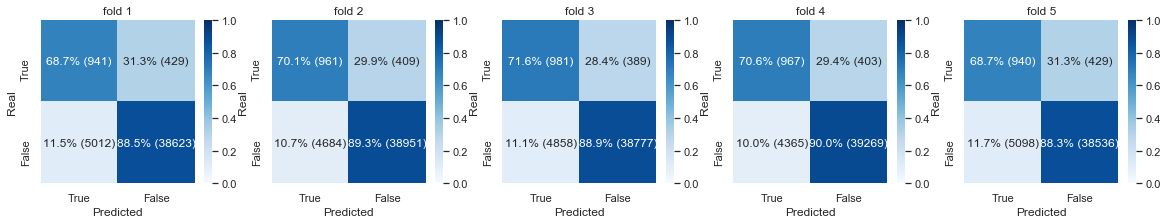

In [36]:
job.metrics.plot_confusion_matrix()

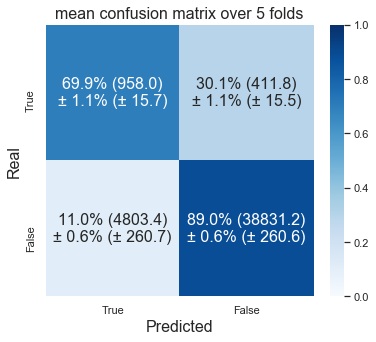

In [37]:
job.metrics.plot_mean_confusion_matrix()

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → randomforestclassifier__criterion   : ['entropy' 'gini']
  → randomforestclassifier__max_depth   : [5 10]
  → randomforestclassifier__n_estimators: [10 20 30]
Best hyperparameters for each fold:
fold 0: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 30}
fold 1: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 30}
fold 2: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 30}
fold 3: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 30}
fold 4: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 30}


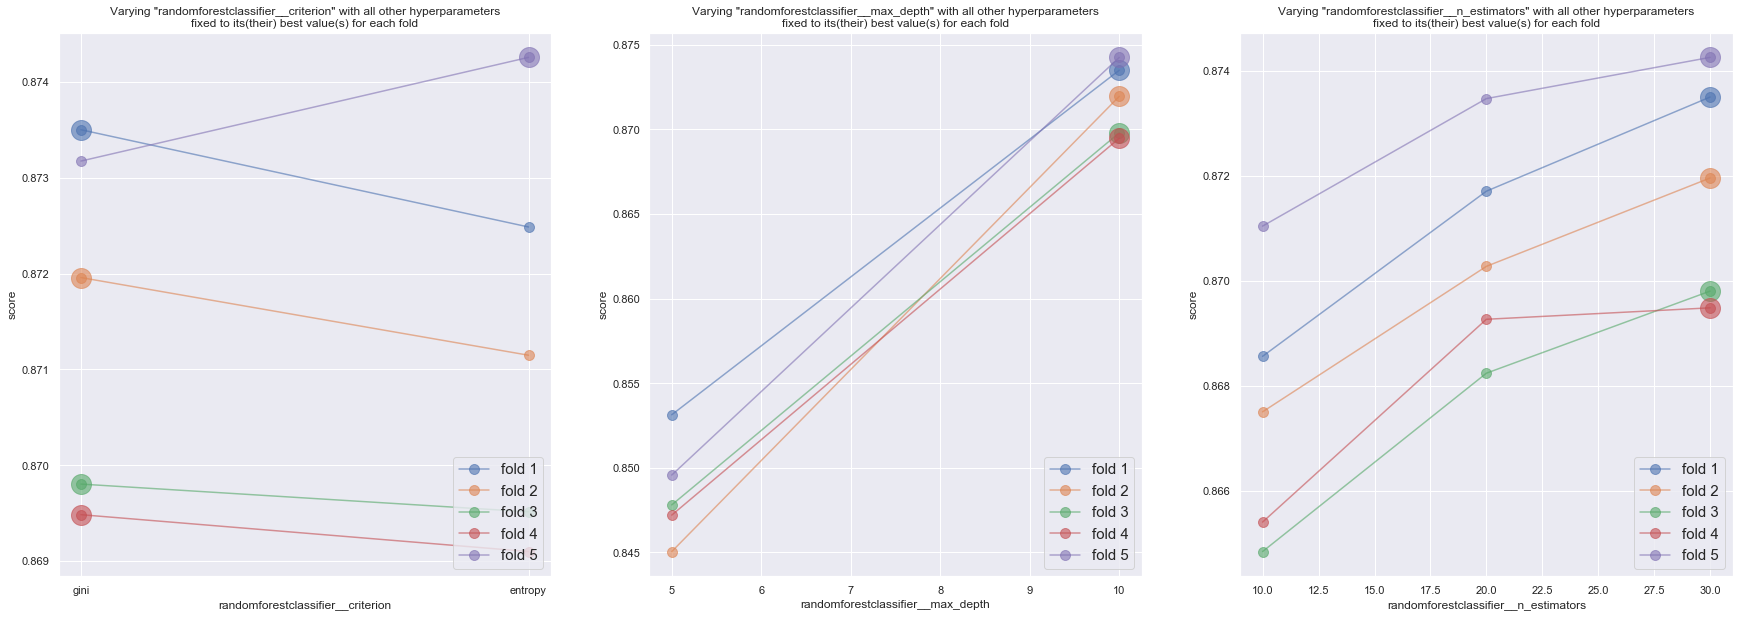

In [38]:
job.metrics.plot_grid_search_results(plot_error_bar=False)

In [39]:
job.remove()

➞ rm on local computer artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
➞ rm on cluster /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest


<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ removed from local computer and cluster<br>